In [1]:

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import ott
import scanpy as sc
import scipy
import sklearn.preprocessing as pp
from entot.models.model import OTFlowMatching
from entot.nets.nets import (MLP_bridge, MLP_vector_field)
from ott.solvers.linear import acceleration, sinkhorn
from scanpy import pl
from sklearn import preprocessing as pp

In [2]:
adata_well01OB_norm = sc.read('../../data/adata_well01OB_norm.h5ad')
adata_well1_5OB_norm = sc.read('../../data/adata_well1_5OB_norm.h5ad')

/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
adata_well01OB_norm, adata_well1_5OB_norm

(AnnData object with n_obs × n_vars = 15791 × 1022
     obs: 'X', 'Y', 'Z', 'Main_molecular_cell_type', 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type'
     uns: 'Main_molecular_tissue_region_colors', 'log1p', 'rank_genes_groups'
     obsm: 'spatial', 'spatial_full'
     layers: 'log_normalized',
 AnnData object with n_obs × n_vars = 19870 × 1022
     obs: 'X', 'Y', 'Z', 'Main_molecular_cell_type', 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type'
     uns: 'Main_molecular_tissue_region_colors', 'log1p', 'rank_genes_groups'
     obsm: 'spatial', 'spatial_full'
     layers: 'log_normalized')

In [4]:
sc.pp.neighbors(adata_well01OB_norm, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_well01OB_norm)

sc.pp.neighbors(adata_well1_5OB_norm, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_well1_5OB_norm)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


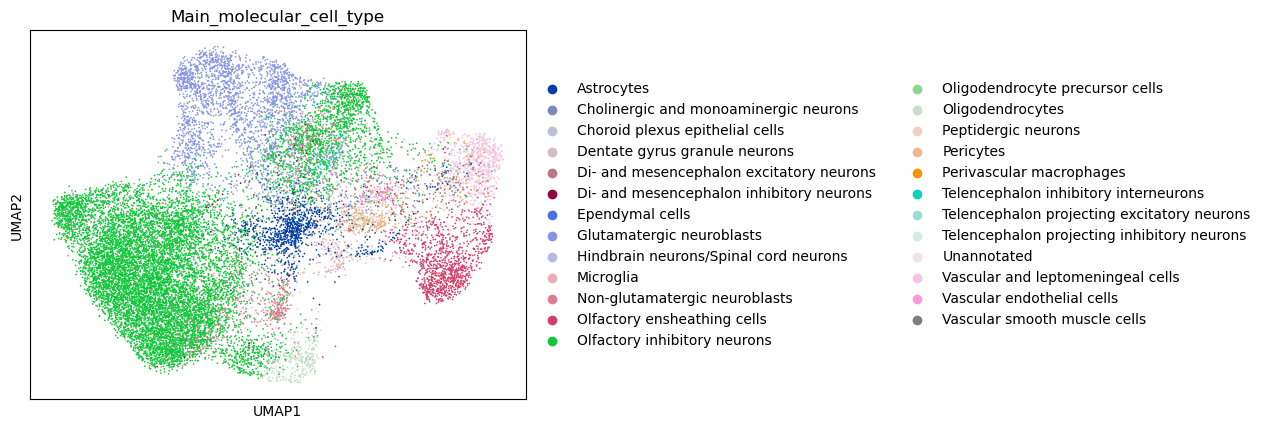

In [5]:
pl.umap(adata_well1_5OB_norm, color=['Main_molecular_cell_type'])

/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


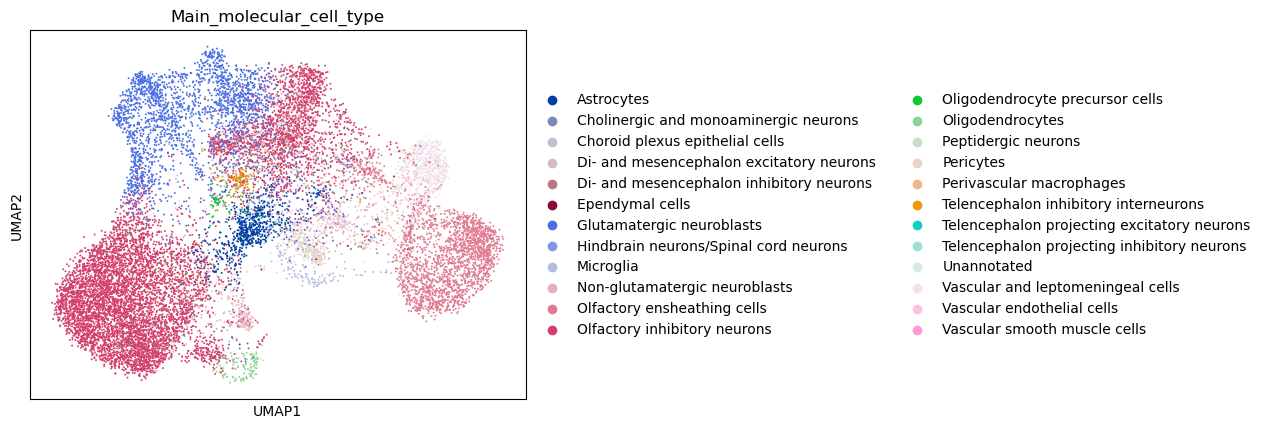

In [6]:
pl.umap(adata_well01OB_norm, color=['Main_molecular_cell_type'])

In [7]:

# Here one important thing is that sizes of these two datasets are different.
# I think in the notebook they are assumed to be the same so I will try to make them the same size.


adata_source=adata_well01OB_norm.copy()
adata_target=adata_well1_5OB_norm.copy()



In [8]:

# Subsampling step, done to be able to run the code on my laptop
new_size = 200
inds_subsample_tgt = np.asarray(jax.random.choice(jax.random.PRNGKey(0), len(adata_target), (new_size,), replace=False))
adata_target = adata_target[inds_subsample_tgt]
inds_subsample_src = np.asarray(jax.random.choice(jax.random.PRNGKey(0), len(adata_source), (new_size,), replace=False))
adata_source = adata_source[inds_subsample_src]



In [9]:
n_cells_source=len(adata_source)

n_samples_train = int(n_cells_source * 0.6)
n_samples_test = n_cells_source - n_cells_source



inds_train = np.asarray(jax.random.choice(jax.random.PRNGKey(0), n_cells_source, (n_samples_train,), replace=False))
inds_test = list(set(list(range(n_cells_source))) - set(np.asarray(inds_train)))

In [10]:


fused = np.concatenate((adata_source.X.toarray(), adata_target.X.toarray()), axis=0)
fused = sc.pp.pca(fused, n_comps=25)

source_fused = fused[:len(adata_source), :]
target_fused = fused[len(adata_target):, :]

source_q = pp.normalize(
    # adata_source.obsm["ATAC_lsi_red"], norm="l2"
    adata_source.obsm['spatial_full'], norm='l2'
) 
# target_q = adata_target.obsm["GEX_X_pca"]
target_q = adata_target.obsm['X_pca']




/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [11]:
source_train_q = source_q[inds_train, :]
source_test_q = source_q[inds_test, :]
target_train_q = target_q[inds_train, :]
target_test_q = target_q[inds_test, :]
source_train_fused = source_fused[inds_train, :]
source_test_fused = source_fused[inds_test, :]
target_train_fused = target_fused[inds_train, :]
target_test_fused = target_fused[inds_test, :]

source_train = np.concatenate((source_train_fused, source_train_q), axis=1)
source_test = np.concatenate((source_test_fused, source_test_q), axis=1)
target_train = np.concatenate((target_train_fused, target_train_q), axis=1)
target_test = np.concatenate((target_test_fused, target_test_q), axis=1)

adata_source_train = adata_source[inds_train,:]
adata_source_test = adata_source[inds_test,:]

adata_target_train = adata_target[inds_train,:]
adata_target_test = adata_target[inds_test,:]

In [12]:
adata_source_train.obsm["emb"] = source_train
adata_source_test.obsm["emb"] = source_test
adata_target_train.obsm["emb"] = target_train
adata_target_test.obsm["emb"] = target_test

adata_source_train.obsm["emb_q"] = source_train_q
adata_source_test.obsm["emb_q"] = source_test_q
adata_target_train.obsm["emb_q"] = target_train_q
adata_target_test.obsm["emb_q"] = target_test_q

adata_source_train.obsm["emb_fused"] = source_train_fused
adata_source_test.obsm["emb_fused"] = source_test_fused
adata_target_train.obsm["emb_fused"] = target_train_fused
adata_target_test.obsm["emb_fused"] = target_test_fused

/var/folders/w4/rlbyb2md7y50tspf85v1lc440000gn/T/ipykernel_8577/3633240122.py:1: ImplicitModificationWarning: Setting element `.obsm['emb']` of view, initializing view as actual.
  adata_source_train.obsm["emb"] = source_train
/var/folders/w4/rlbyb2md7y50tspf85v1lc440000gn/T/ipykernel_8577/3633240122.py:2: ImplicitModificationWarning: Setting element `.obsm['emb']` of view, initializing view as actual.
  adata_source_test.obsm["emb"] = source_test
/var/folders/w4/rlbyb2md7y50tspf85v1lc440000gn/T/ipykernel_8577/3633240122.py:3: ImplicitModificationWarning: Setting element `.obsm['emb']` of view, initializing view as actual.
  adata_target_train.obsm["emb"] = target_train
/var/folders/w4/rlbyb2md7y50tspf85v1lc440000gn/T/ipykernel_8577/3633240122.py:4: ImplicitModificationWarning: Setting element `.obsm['emb']` of view, initializing view as actual.
  adata_target_test.obsm["emb"] = target_test


In [13]:
neural_net = MLP_vector_field(target_train.shape[1], latent_embed_dim = 128, num_layers=8, n_frequencies=128)
bridge_net = MLP_bridge(target_train.shape[1], 10)
linear_ot_solver = sinkhorn.Sinkhorn(
                momentum=acceleration.Momentum(value=1., start=25)
        )
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=0.01, linear_ot_solver=linear_ot_solver)

otfm = OTFlowMatching(neural_net, bridge_net, epsilon=None, scale_cost="mean", input_dim=source_train.shape[1], output_dim=target_train.shape[1], iterations=20_000, ot_solver=solver, k_noise_per_x=1, fused_penalty = 1.0, split_dim=fused.shape[1])

In [14]:
otfm(source_train, target_train, 20, 20)

100%|██████████| 20000/20000 [02:39<00:00, 125.12it/s]


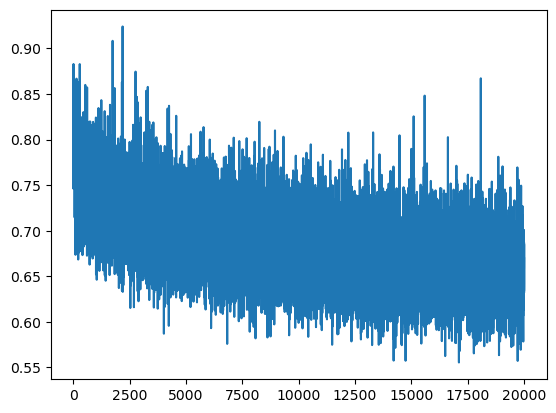

In [15]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

In [16]:
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

In [17]:
res_train = [None] * 30
res_test = [None] * 30

for i in range(30):
    res_train[i] = otfm.transport(source_train, seed=i)[0][0,...] # TODO: what is done here?
    res_test[i] = otfm.transport(source_test, seed=i)[0][0,...]

In [18]:
cond_mean_train = jnp.mean(jnp.asarray(res_train), axis=0)
cond_mean_test = jnp.mean(jnp.asarray(res_test), axis=0)

In [19]:
foscttm(res_train[0], target_train)

0.478

In [20]:
foscttm(res_test[0], target_test)

0.4877

In [21]:
foscttm(cond_mean_train, target_train)

0.4947

In [22]:
foscttm(cond_mean_test, target_test)

0.5098

/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-pa

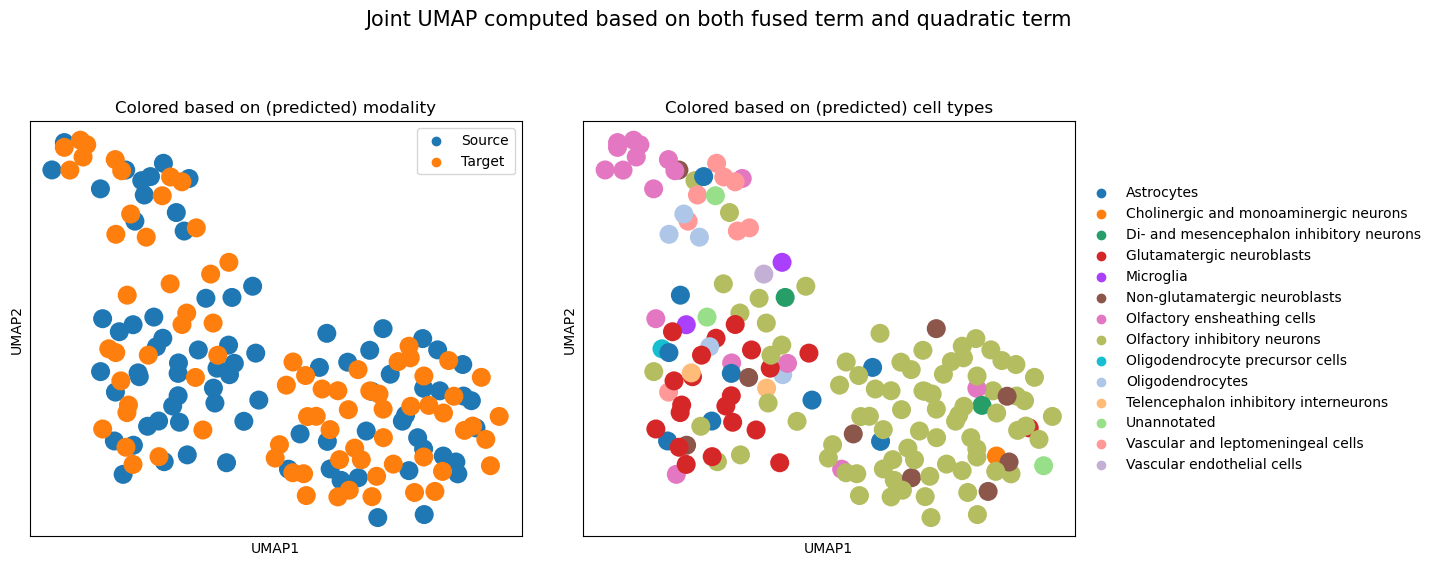

In [23]:
adata_one_sample = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="batch",
    keys=["Source", "Target"],
)
adata_one_sample.obsm["X_translated_1"] = np.concatenate(
    (res_test[0], target_test), axis=0
)
sc.pp.neighbors(adata_one_sample, use_rep="X_translated_1")
sc.tl.umap(adata_one_sample)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Joint UMAP computed based on both fused term and quadratic term", size=15)
sc.pl.umap(adata_one_sample, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality")
sc.pl.umap(adata_one_sample, color=["Main_molecular_cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on (predicted) cell types")
plt.tight_layout(pad=3.0)
plt.show()

/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-pa

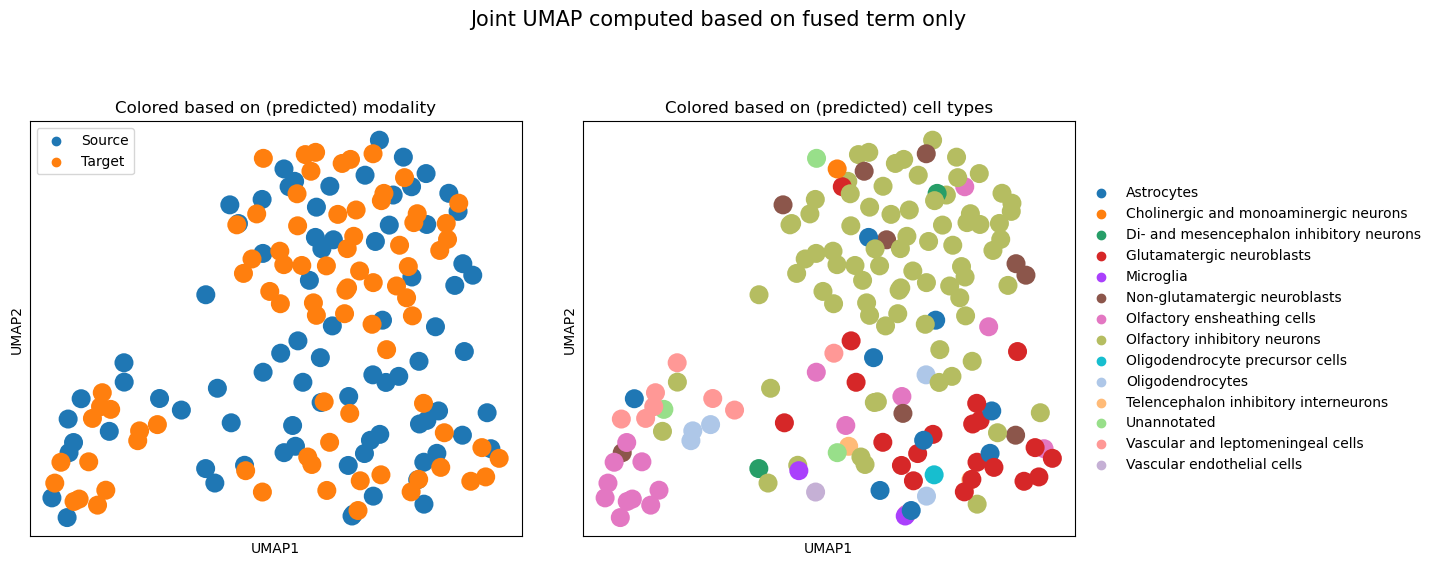

In [24]:
adata_one_sample = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="batch",
    keys=["Source", "Target"],
)
adata_one_sample.obsm["X_translated_1"] = np.concatenate(
    (res_test[0][...,:fused.shape[1]], target_test[...,:fused.shape[1]]), axis=0
)
sc.pp.neighbors(adata_one_sample, use_rep="X_translated_1")
sc.tl.umap(adata_one_sample)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Joint UMAP computed based on fused term only", size=15)
sc.pl.umap(adata_one_sample, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality")
sc.pl.umap(adata_one_sample, color=["Main_molecular_cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on (predicted) cell types")
plt.tight_layout(pad=3.0)
plt.show()

/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-pa

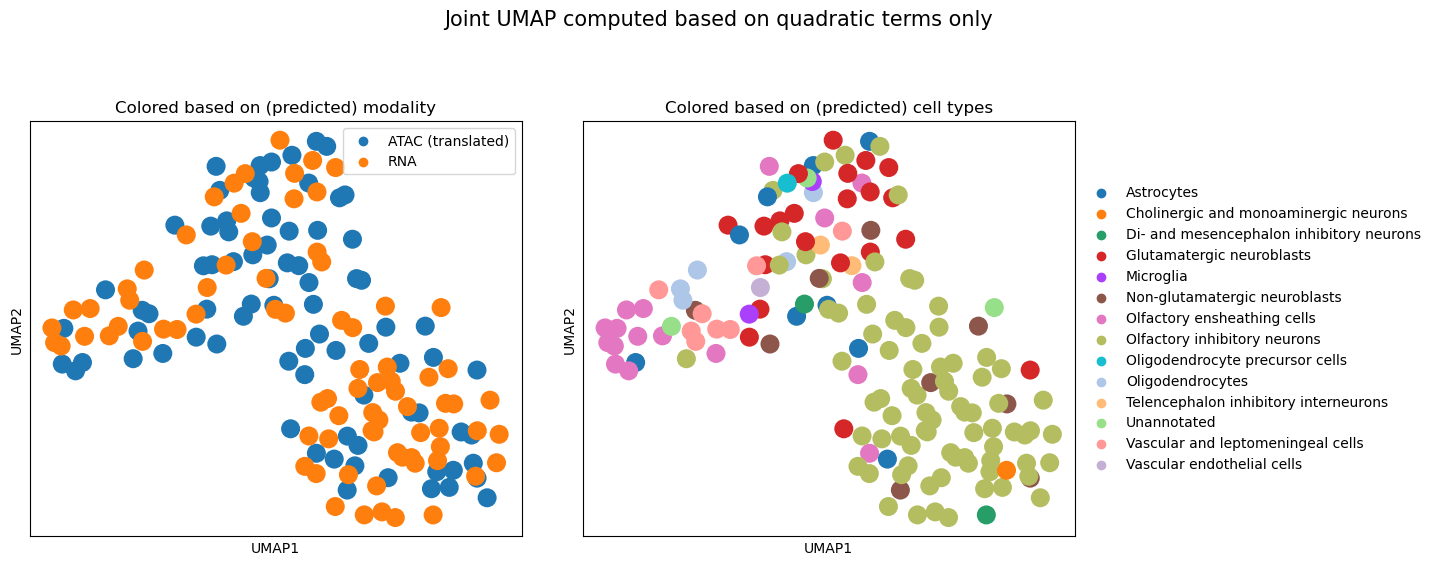

In [25]:
adata_one_sample = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata_one_sample.obsm["X_translated_1"] = np.concatenate(
    (res_test[0][...,fused.shape[1]:], target_test[...,fused.shape[1]:]), axis=0
)
sc.pp.neighbors(adata_one_sample, use_rep="X_translated_1")
sc.tl.umap(adata_one_sample)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Joint UMAP computed based on quadratic terms only", size=15)
sc.pl.umap(adata_one_sample, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality")
sc.pl.umap(adata_one_sample, color=["Main_molecular_cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on (predicted) cell types")
plt.tight_layout(pad=3.0)
plt.show()

/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-pa

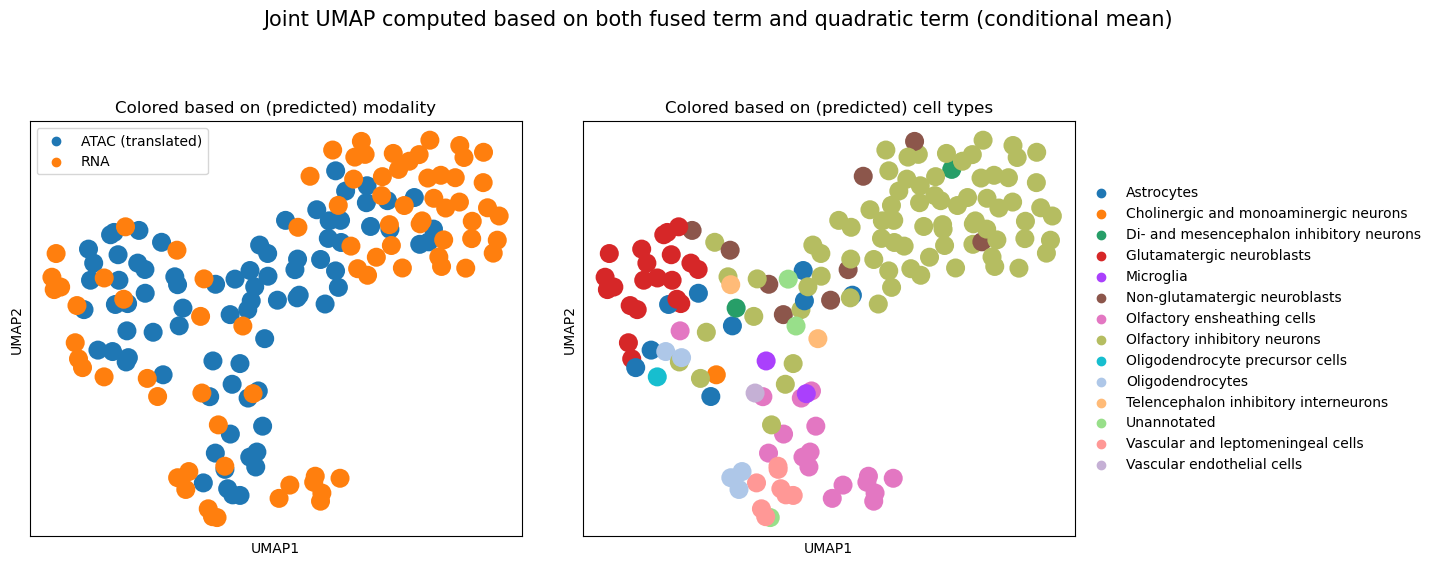

In [26]:
adata_cond_mean = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata_cond_mean.obsm["X_translated_1"] = np.concatenate(
    (cond_mean_test, target_test), axis=0
)
sc.pp.neighbors(adata_cond_mean, use_rep="X_translated_1")
sc.tl.umap(adata_cond_mean)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Joint UMAP computed based on both fused term and quadratic term (conditional mean)", size=15)
sc.pl.umap(adata_cond_mean, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality")
sc.pl.umap(adata_cond_mean, color=["Main_molecular_cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on (predicted) cell types")
plt.tight_layout(pad=3.0)
plt.show()

/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-pa

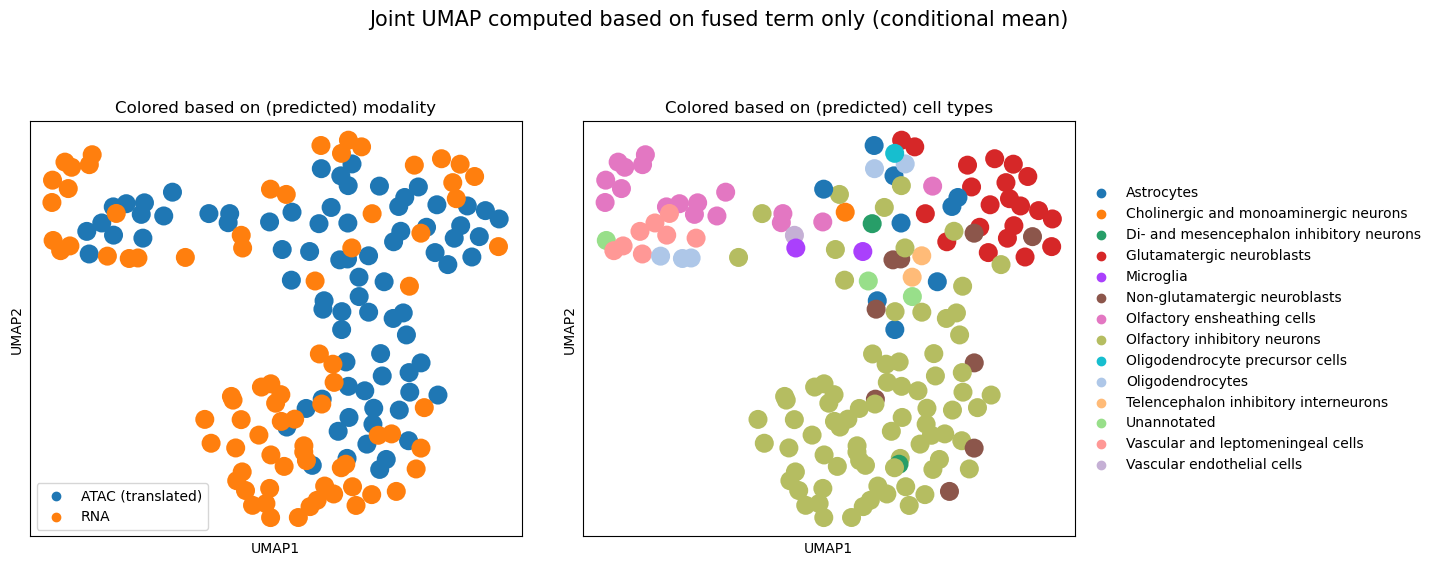

In [27]:
adata_cond_mean = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata_cond_mean.obsm["X_translated_1"] = np.concatenate(
    (cond_mean_test[:, :fused.shape[1]], target_test[:, :fused.shape[1]]), axis=0
)
sc.pp.neighbors(adata_cond_mean, use_rep="X_translated_1")
sc.tl.umap(adata_cond_mean)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Joint UMAP computed based on fused term only (conditional mean)", size=15)
sc.pl.umap(adata_cond_mean, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality")
sc.pl.umap(adata_cond_mean, color=["Main_molecular_cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on (predicted) cell types")
plt.tight_layout(pad=3.0)
plt.show()

/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-pa

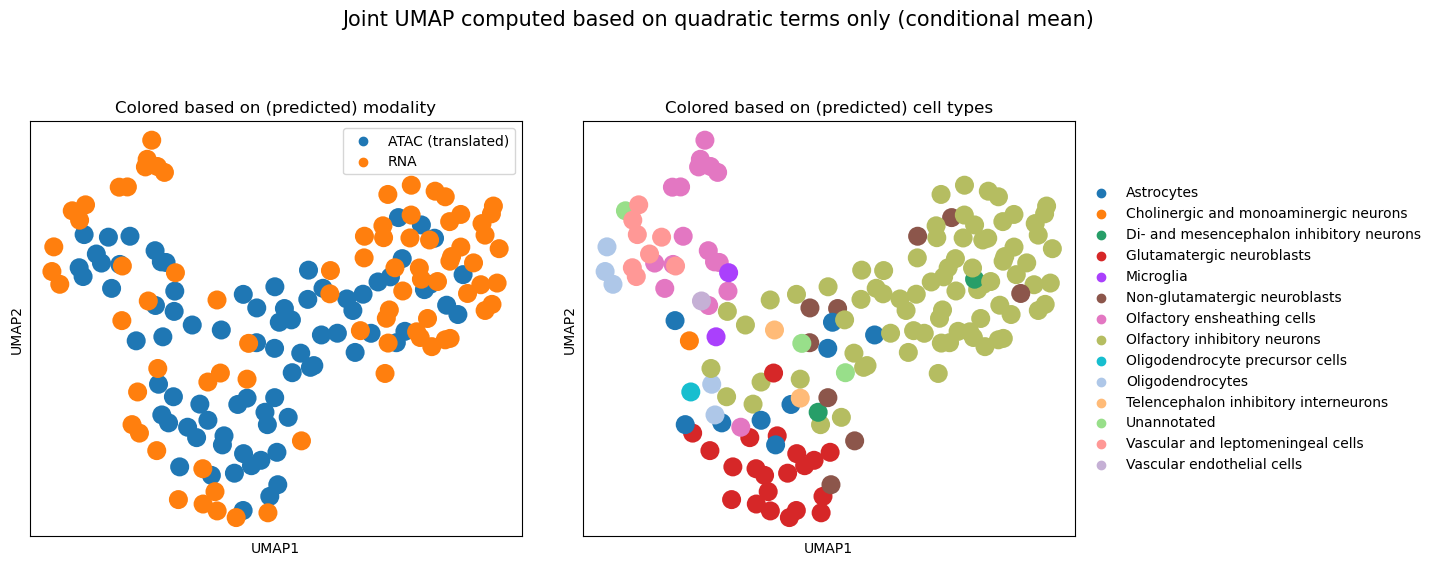

In [28]:
adata_cond_mean = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata_cond_mean.obsm["X_translated_1"] = np.concatenate(
    (cond_mean_test[:, fused.shape[1]:], target_test[:, fused.shape[1]:]), axis=0
)
sc.pp.neighbors(adata_cond_mean, use_rep="X_translated_1")
sc.tl.umap(adata_cond_mean)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Joint UMAP computed based on quadratic terms only (conditional mean)", size=15)
sc.pl.umap(adata_cond_mean, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality")
sc.pl.umap(adata_cond_mean, color=["Main_molecular_cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on (predicted) cell types")
plt.tight_layout(pad=3.0)
plt.show()

In [29]:
samples = jnp.array(res_test)
vars = jnp.var(samples, axis=0)
vars_summed = jnp.sum(vars, axis=1)

In [30]:
adata_source_test.obs["var"] = vars_summed

/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/selman.ozleyen/mambaforge/envs/moscot/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


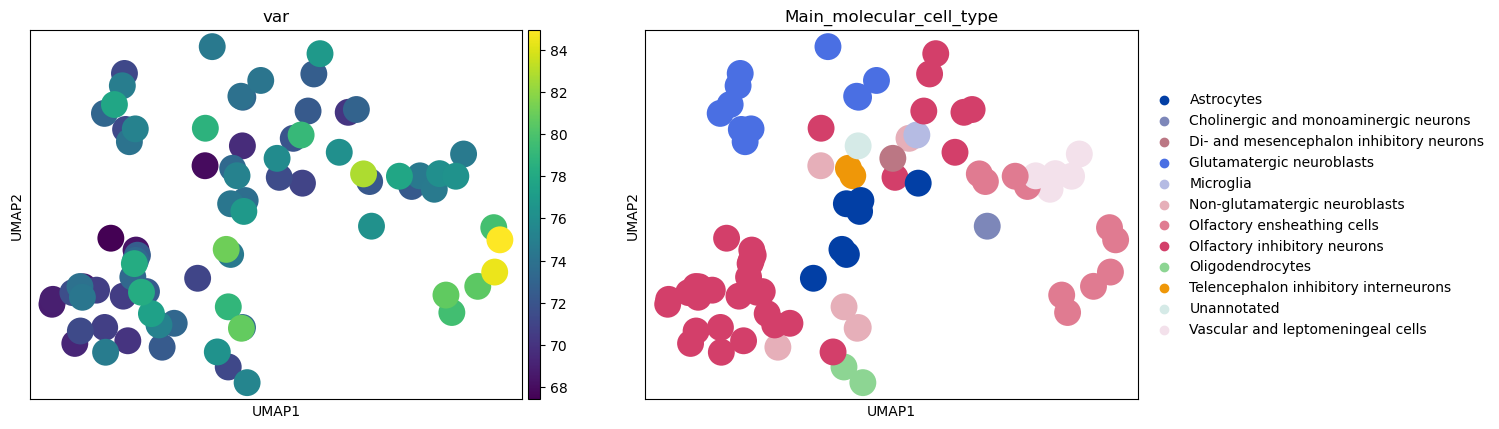

In [31]:
sc.pl.umap(adata_source_test, color=["var", "Main_molecular_cell_type"])

In [32]:
adata_source_test.obs[["Main_molecular_cell_type", "var"]].groupby("Main_molecular_cell_type").mean()

/var/folders/w4/rlbyb2md7y50tspf85v1lc440000gn/T/ipykernel_8577/1772010429.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_source_test.obs[["Main_molecular_cell_type", "var"]].groupby("Main_molecular_cell_type").mean()


,var
Main_molecular_cell_type,
Astrocytes,74.629204
Cholinergic and monoaminergic neurons,76.199104
Di- and mesencephalon inhibitory neurons,75.837242
Glutamatergic neuroblasts,73.942986
Microglia,79.142731
Non-glutamatergic neuroblasts,74.228622
Olfactory ensheathing cells,79.500175
Olfactory inhibitory neurons,72.744225
Oligodendrocytes,73.320847
